# Example code to create a count table 

In [74]:
import numpy as np
import pandas as pd
from kipoiseq.extractors import MultiSampleVCF
from count_table.dataclasses import Junction
from count_table import CountTable, infer_junction_strand
from kipoiseq.extractors import FastaStringExtractor
from kipoiseq import Interval
import matplotlib.pyplot as plt

## 1) Read in example file

In [75]:
path = '/s/project/gtex-processed/mmsplice-scripts/data/processed/junction-annotation/Brain_Cortex_raw_count_table.csv'
ct = CountTable.read_csv(path)

In [77]:
ct_df = pd.read_csv(path)

/opt/modules/i12g/anaconda/envs/nils-mmsplice-scripts/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [99]:
print(ct_df[ct_df.iloc[0::,4:10].gt(2).any(axis=1)].iloc[0:10,0:10].to_markdown())

|     |   Chromosome |   Start |    End | Strand   |   GTEX-111FC |   GTEX-1128S |   GTEX-117XS |   GTEX-1192X |   GTEX-11DXW |   GTEX-11DXY |
|----:|-------------:|--------:|-------:|:---------|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|
|  23 |            1 |   17729 |  17733 | +        |            9 |            0 |            0 |            0 |            0 |            7 |
|  32 |            1 |   30667 |  30975 | +        |            8 |            1 |            7 |            3 |            5 |            5 |
|  43 |            1 |  135802 | 137620 | +        |            0 |            2 |            2 |            0 |            3 |            1 |
|  70 |            1 |  320653 | 320880 | +        |            1 |            1 |            4 |            1 |            2 |            4 |
|  73 |            1 |  320653 | 324287 | +        |            0 |            2 |            8 |            1 |            0 |            2 |

In [97]:
print(ct_df[ct_df.iloc[0::,4:10].gt(2).any(axis=1)].iloc[0:10,1:10].to_markdown())

|     |   Start |    End | Strand   |   GTEX-111FC |   GTEX-1128S |   GTEX-117XS |   GTEX-1192X |   GTEX-11DXW |   GTEX-11DXY |
|----:|--------:|-------:|:---------|-------------:|-------------:|-------------:|-------------:|-------------:|-------------:|
|  23 |   17729 |  17733 | +        |            9 |            0 |            0 |            0 |            0 |            7 |
|  32 |   30667 |  30975 | +        |            8 |            1 |            7 |            3 |            5 |            5 |
|  43 |  135802 | 137620 | +        |            0 |            2 |            2 |            0 |            3 |            1 |
|  70 |  320653 | 320880 | +        |            1 |            1 |            4 |            1 |            2 |            4 |
|  73 |  320653 | 324287 | +        |            0 |            2 |            8 |            1 |            0 |            2 |
|  75 |  320938 | 321031 | +        |            2 |            4 |            5 |            3 |       

In [83]:
ct_df.iloc[0:10,4:10]

,GTEX-111FC,GTEX-1128S,GTEX-117XS,GTEX-1192X,GTEX-11DXW,GTEX-11DXY
0,1,0,0,0,0,0
1,0,0,0,0,0,0
2,1,0,1,0,0,1
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,2,0,0,0,0
6,0,0,0,0,0,0
7,0,0,0,0,1,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


## 2) Use quality filters to generate a reference table

Notes for provided quality filters in the count_table package:

'_is_expressed_events' uses GaussianMixture model (no hard cutoff). This underestimates. Reports lots of regions to be expressed, although they are not expressed
Therefore currently '_median_filter' is used, which uses a hard cutoff. As a cutoff for the GTEs data 50 was chosen

### 2.1) Quantile filter
We first use 'quantile_filter', which filters for junctions that are observed in at least 5% of the samples

In [5]:
ct_quantile_filtered = ct.quantile_filter()

### 2.1) Median filter
We use 'event5_median_filter' and 'event3_median_filter', which filters for events/splice-sites that have a median count over a certain cutoff value. Note that results depend a lot on the choice of this cutoff value

In [6]:
cutoff = 50
ct_psi5 = ct_quantile_filtered.event5_median_filter(cutoff=cutoff)
ct_psi3 = ct_quantile_filtered.event3_median_filter(cutoff=cutoff)

In [7]:
df_psi5 = ct_psi5.ref_psi5()
df_psi3 = ct_psi3.ref_psi3()

In [8]:
df_psi5

,ref_psi,k,n
junctions,,,
1:324345-324438:+,1.000000,6640,6640
1:948956-949363:+,1.000000,19049,19049
1:977082-977335:+,0.996254,5319,5339
1:977082-977340:+,0.003746,20,5339
1:978837-978917:+,0.998842,5176,5182
...,...,...,...
Y:21868231-21868326:-,1.000000,6502,6502
Y:21868494-21868679:-,0.081702,455,5569
Y:21868526-21868679:-,0.918298,5114,5569


## 3) Investigate variants and outliers

In [9]:
vcf_file = '/s/project/gtex-processed/mmsplice-scripts/data/raw/gtex/GTEx_Analysis_2016-01-15_v7_WholeGenomeSeq_635Ind_PASS_AB02_GQ20_HETX_MISS15_PLINKQC.vcf.gz'
vcf = MultiSampleVCF(vcf_file)

In [10]:
outliers_psi5 = '/s/project/gtex-processed/mmsplice-scripts/data/processed/outlier-prediction/Brain_Cortex_outliers_psi5.csv'
outliers_psi3 = '/s/project/gtex-processed/mmsplice-scripts/data//processed/outlier-prediction/Brain_Cortex_outliers_psi3.csv'
df_outliers_psi5 = pd.read_csv(outliers_psi5)
df_outliers_psi3 = pd.read_csv(outliers_psi3)

In [11]:
i = 0
df_outliers_psi5['junctions'][i]

'11:47600710-47600820:+'

With 'Interval' from kipoiseq look at intronic region, start pos is donor, end pos is acceptor. There is no variant in the intronic region in this case.

In [12]:
intronic_region = Interval.from_str(df_outliers_psi5['junctions'][i])
list(vcf.fetch_variants(intronic_region))

[]

With 'Junction' from count_table look at 100bp window around acceptor or donor site. There is 1 variant in the region around the acceptor site.

In [13]:
j = Junction.from_str(df_outliers_psi5['junctions'][i])
list(vcf.fetch_variants(j.acceptor_region()))

[Variant(chrom='11', pos=47600886, ref='CGTGA', alt='C', id='11_47600886_CGTGA_C_b37',...)]

There are 2 variants in the region around the donor site

In [14]:
list(vcf.fetch_variants(j.donor_region()))

[Variant(chrom='11', pos=47600620, ref='CT', alt='C', id='11_47600620_CT_C_b37',...),
 Variant(chrom='11', pos=47600645, ref='T', alt='G', id='11_47600645_T_G_b37',...)]

We can further investigate those variants with functionalities from kipoiseq

In [15]:
va0 = list(vcf.fetch_variants(j.acceptor_region()))[0]
vd0 = list(vcf.fetch_variants(j.donor_region()))[0]
vd1 = list(vcf.fetch_variants(j.donor_region()))[1]

In [16]:
vcf.get_samples(va0), vcf.get_samples(vd0), vcf.get_samples(vd1)

({'GTEX-WHSE': 1}, {'GTEX-11EQ9': 1}, {'GTEX-12ZZX': 1})

Looking at the outlier, we see that the variant is on the acceptor site (same sample). This makes sense, as it is a psi5 outlier

In [17]:
df_outliers_psi5.loc[i]

junctions                           11:47600710-47600820:+
sample                                           GTEX-WHSE
pval                                            4.1577e-09
gene_id                               ENSG00000213619.10_4
gene_name                                           NDUFS3
events       11:47600710-47600820:+;11:47600710-47602076:+
variants                               11:47600886:CGTGA>C
Name: 0, dtype: object

In [18]:
# Check minor allele frequency
va0.source, va0.source.aaf

(Variant(11:47600886 CGTGA/C), 0.0007874015748031496)

## 4) Plotting features

In [69]:
i = 0
row = df_outliers_psi5.loc[i]

### With 'plot_kn{5,3}', 'plot_psi{5,3}', and 'plot_psi{5,3}_variants' we can visualize outliers

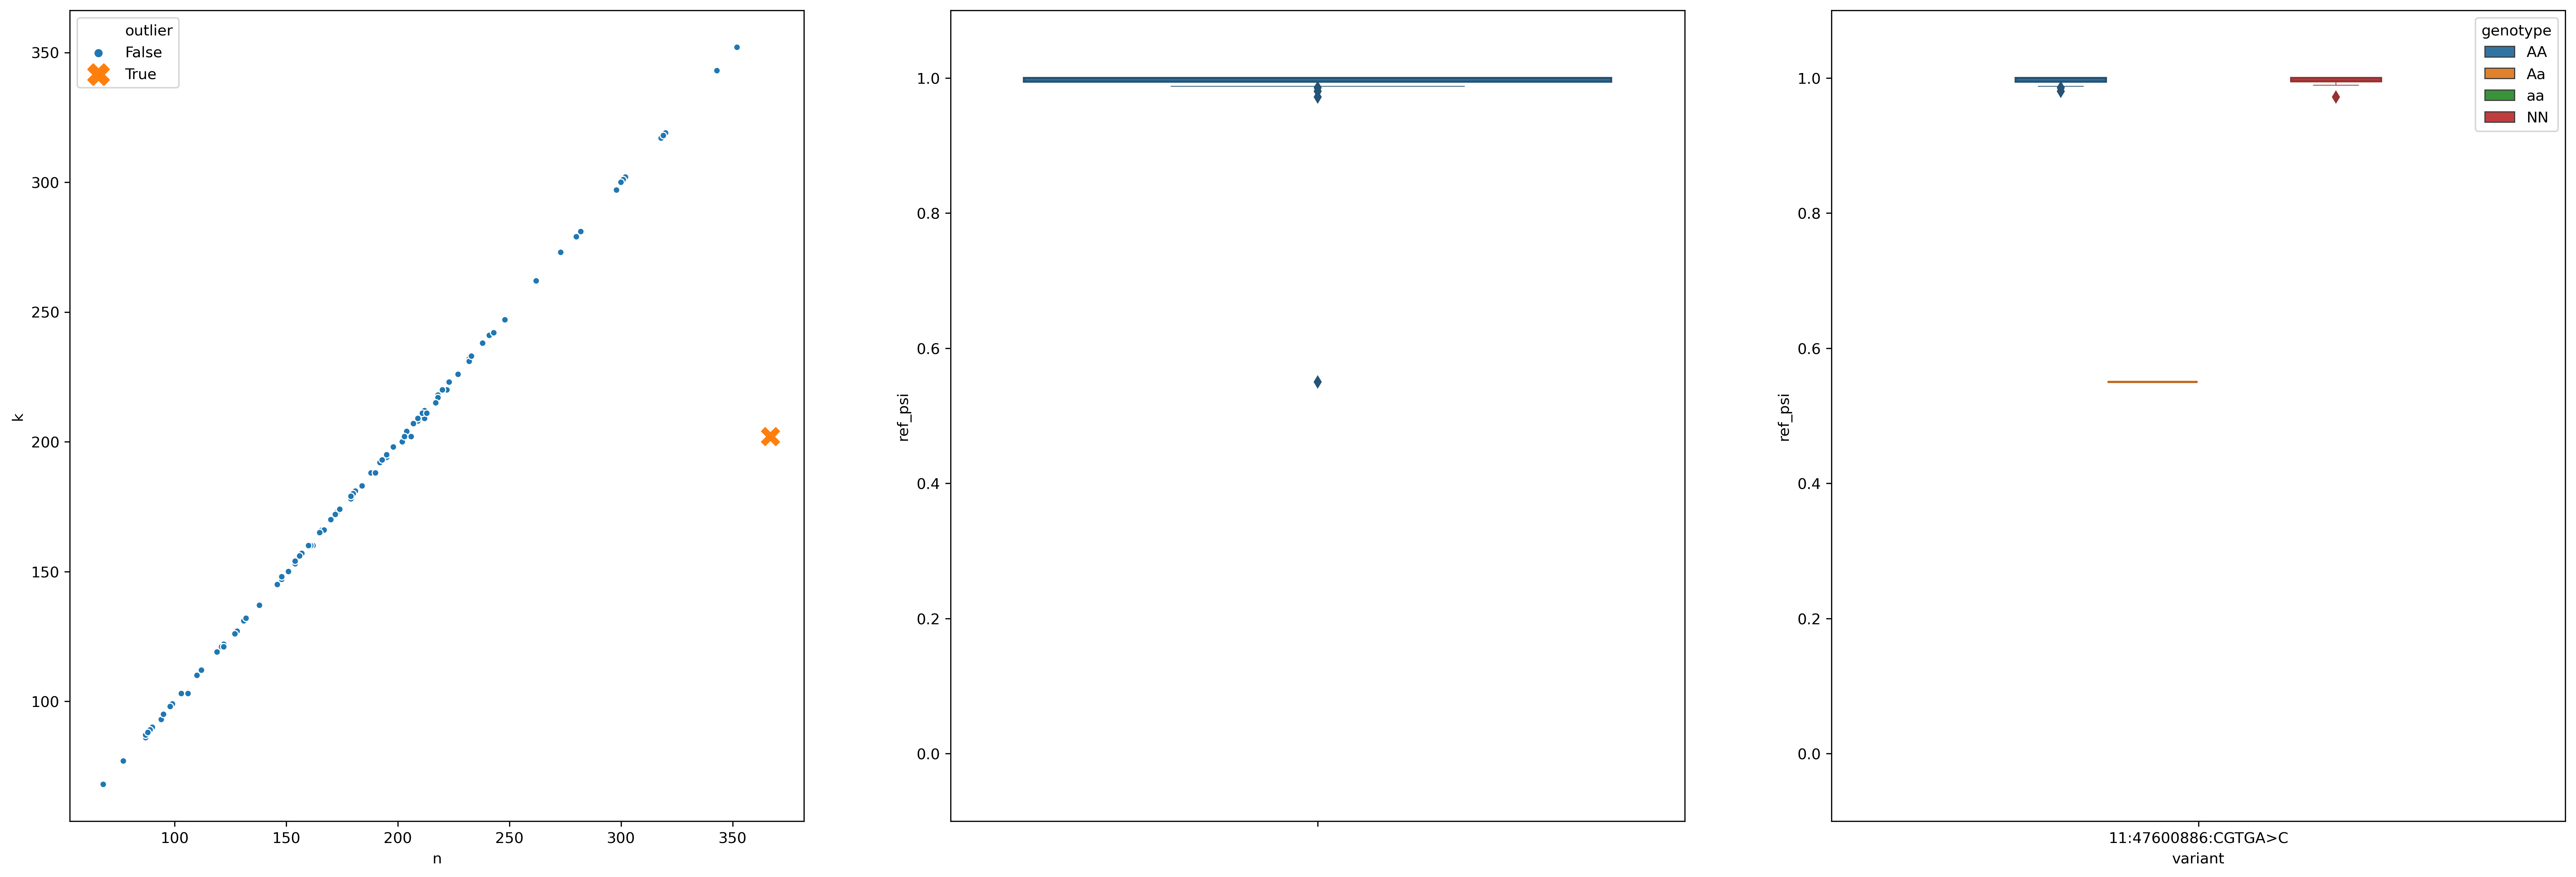

In [70]:
plt.figure(figsize=(30,10), dpi=300)
plt.subplot(1, 3, 1)
ct_psi5.plot_kn5(row['junctions'], highlight=[row['sample']])

plt.subplot(1, 3, 2)
ct_psi5.plot_psi5(row['junctions'])

plt.subplot(1, 3, 3)
ct_psi5.plot_psi5_variants(row['junctions'], vcf)

In [71]:
# plt.figure(figsize=(5,5), dpi=150)
# ct_psi5.plot_kn5(row['junctions'], highlight=[row['sample']])

In [72]:
# plt.figure(figsize=(5,5), dpi=150)
# ct_psi5.plot_psi5(row['junctions'])

In [73]:
# plt.figure(figsize=(5,5), dpi=150)
# ct_psi5.plot_psi5_variants(row['junctions'], vcf)

In [60]:
# if True:
#     %pdb
#     current_junction = ct_psi5.junctions[0]
#     ct_psi5.plot_psi5_variants(current_junction, vcf)
